In [1]:
### Imports ###

from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import pandas as pd
import matplotlib.pyplot as plt
import glob
import json
import scipy.stats
import numpy as np

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from sklearn.preprocessing import LabelEncoder


2024-11-18 14:34:30.306830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 14:34:30.357145: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 14:34:30.370399: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 14:34:30.447695: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 14:34:31.633984: W tensorflow/compiler/tf2

In [3]:
# Load VA classifier from https://doi.org/10.1007/978- 3- 031- 28244- 7_6
dirpath='/home/andreas/Downloads/XLM-RoBERTa-large MSE/XLM-RoBERTa-large MSE/'
model_path='[path to dir]'+'XLM-RoBERTa-large MSE/'
model_path=dirpath
config = AutoConfig.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, return_dict=True)
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)


/home/andreas/PythonProjects/venvs/default/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
# setup the classifer
# remove device='cuda' if running on CPU only
# batch size depends on your CPU/GPU
classifier = pipeline(task="text-classification", 
                      model=model, 
                      tokenizer=tokenizer, 
                      config=config, 
                      batch_size=16, device='cuda')


In [5]:
#### LLM generated phrases analysis

In [6]:
# function to plot confidence ellipses in scatter plots

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ellipse, mean_x, mean_y

In [7]:
# function to get va scores as discrete lists from va classifier
def get_score_lists(scores):
    valences = []
    arousals = []
    for score in scores:
        for subscore in score:
            if subscore['label']== 'LABEL_0':
                valences.append(subscore['score'])
            else:
                arousals.append(subscore['score'])
    return [valences, arousals]

In [47]:
def bincalc(series):
    range = max(series)-min(series)
    print(min(series), max(series))
    return [min(series)-0.01, min(series)+0.4*range, min(series)+0.6*range, max(series)]
    

# function to read and process generated phrase files

def process_files(path, classifier, field):

    #find necessary files
    
    result_files = glob.glob(path + "**")
    print ("found "+str(result_files))

    #create dataframe to hold data
    dfx = pd.DataFrame(columns=['response', 'valence', 'arousal'])

    #read and process from each file
    for filepath in result_files:
        with open(filepath) as file:
            print('----')
            print(filepath)
            print('---')
            convos = json.load(file)

        responses = []
        valences = []
        arousals = []
        
        for convo in convos['results']:
            try:
                v = convo['valence']
                a = convo['arousal']
                for sample in convo['samples']:
                    r = sample['sample'][field]
                    responses.append(r)
                    valences.append(v/10)
                    arousals.append(a/10)
            except Exception as e:
                print (e)
                continue
        
        newdf = pd.DataFrame()
        newdf['response'] = responses
        newdf['valence'] = valences
        newdf['arousal'] = arousals
        dfx = pd.concat([dfx, newdf], axis=0)
    
    print("ingested ",len(dfx), "records")

    print(len(dfx))
    dfx.dropna(inplace=True)
    print(len(dfx))

    #get emotional VA score
    scores = classifier(list(dfx['response']),function_to_apply="none", top_k=None)
    dfx['rval'] = get_score_lists(scores)[0]
    dfx['rar'] = get_score_lists(scores)[1]

    #do a min-max normalization
    dfx['rvaln'] = (dfx['rval'] - dfx['rval'].min()) / (dfx['rval'].max() - dfx['rval'].min())
    dfx['rarn'] = (dfx['rar'] - dfx['rar'].min()) / (dfx['rar'].max() - dfx['rar'].min())

    # categorise 
    labsV = ['$V^-$', '$V_0$', '$V^+$']
    labsA = ['$A^-$', '$A_0$', '$A^+$']
    
    dfx['valbins']=pd.cut(dfx['valence'], bins=bincalc(dfx['valence']), labels=labsV)
    dfx['arbins']=pd.cut(dfx['arousal'], bins=bincalc(dfx['arousal']), labels=labsA)
    dfx['category'] = dfx['valbins'].astype(str)+" "+dfx['arbins'].astype(str)

    dfx['calcvalbins']=pd.cut(dfx['rvaln'], bins=bincalc(dfx['rvaln']), labels=labsV)
    dfx['calcarbins']=pd.cut(dfx['rarn'], bins=bincalc(dfx['rarn']), labels=labsA)
    dfx['calccategory'] = dfx['calcvalbins'].astype(str)+" "+dfx['calcarbins'].astype(str)
     
    # Creating a instance of label Encoder.
    le = LabelEncoder()
     
    # Using .fit_transform function to fit label
    # encoder and return encoded label
    dfx['catn'] = le.fit_transform(dfx['category'])
    dfx['calccatn'] = le.fit_transform(dfx['calccategory'])

    #ready to return
    print ("Done.")
    return dfx


In [46]:
bincalc(df['valence'])

0.0 1.0


[-0.01, 0.4, 0.6, 1.0]

In [48]:
def recategorise(dfx, labsV, labsA, onnormal=True):
       
    dfx['valbins']=pd.cut(dfx['valence'], bins=bincalc(dfx['valence']), labels=labsV)
    dfx['arbins']=pd.cut(dfx['arousal'], bins=bincalc(dfx['arousal']), labels=labsA)
    dfx['category'] = dfx['valbins'].astype(str)+" "+dfx['arbins'].astype(str)
    if onnormal:
        dfx['calcvalbins']=pd.cut(dfx['rvaln'], bins=bincalc(dfx['rvaln']), labels=labsV)
        dfx['calcarbins']=pd.cut(dfx['rarn'], bins=bincalc(dfx['rarn']), labels=labsA)
        dfx['calccategory'] = dfx['calcvalbins'].astype(str)+" "+dfx['calcarbins'].astype(str)
    else:
        dfx['calcvalbins']=pd.cut(dfx['rval'], bins=bincalc(dfx['rval']), labels=labsV)
        dfx['calcarbins']=pd.cut(dfx['rar'], bins=bincalc(dfx['rar']), labels=labsA)
        dfx['calccategory'] = dfx['calcvalbins'].astype(str)+" "+dfx['calcarbins'].astype(str)
     
    # Creating a instance of label Encoder.
    le = LabelEncoder()
     
    # Using .fit_transform function to fit label
    # encoder and return encoded label
    dfx['catn'] = le.fit_transform(dfx['category'])
    dfx['calccatn'] = le.fit_transform(dfx['calccategory'])

    #ready to return
    print ("Done.")
    return dfx

In [49]:
phrase_dir = '/home/andreas/PythonProjects/llm-sentiment/affective_phrases/'
df=process_files(phrase_dir, classifier, 'final_sentence')

found ['/home/andreas/PythonProjects/llm-sentiment/affective_phrases/va-single-phrases-3-nrc-5.json', '/home/andreas/PythonProjects/llm-sentiment/affective_phrases/va-single-phrases-3-nrc-8.json', '/home/andreas/PythonProjects/llm-sentiment/affective_phrases/va-single-phrases-3-nrc-0.json', '/home/andreas/PythonProjects/llm-sentiment/affective_phrases/va-single-phrases-3-warr-6.json', '/home/andreas/PythonProjects/llm-sentiment/affective_phrases/va-single-phrases-3-warr-9.json', '/home/andreas/PythonProjects/llm-sentiment/affective_phrases/va-single-phrases-3-nrc-3.json', '/home/andreas/PythonProjects/llm-sentiment/affective_phrases/va-single-phrases-3-warr-7.json', '/home/andreas/PythonProjects/llm-sentiment/affective_phrases/va-single-phrases-3-warr-8.json', '/home/andreas/PythonProjects/llm-sentiment/affective_phrases/va-single-phrases-3-nrc-6.json', '/home/andreas/PythonProjects/llm-sentiment/affective_phrases/va-single-phrases-3-nrc-4.json', '/home/andreas/PythonProjects/llm-senti

/tmp/ipykernel_497035/1255680006.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfx = pd.concat([dfx, newdf], axis=0)


0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
Done.


In [50]:
#### Now explore the generated phrases

# response -> generated phrase
# valence, arousal -> generating anchor point's VA classification
# rval, rar -> raw valence, arousal according to classifier
# rvaln, rarn -> normalised valence, arousal
# valbins, arbins, category -> nominal anchor point valence, arousal, final 2D classification
# calcvalbins, calcarbins, calccategory -> nominal normalised valence, arousal, final 2D classification
# catn, calccatn -> numeral representation of anchor point and phrase final 2D category

df.head(5)

,response,valence,arousal,rval,rar,rvaln,rarn,valbins,arbins,category,calcvalbins,calcarbins,calccategory,catn,calccatn
0,Inactivity can lead to unsound decision-making,0.0,0.0,-0.845205,-0.463982,0.343472,0.471999,$V^-$,$A^-$,$V^-$ $A^-$,$V^-$,$A_0$,$V^-$ $A_0$,4,5
1,The sloth's lack of activity promotes passivity,0.0,0.0,-0.349461,-0.724272,0.433420,0.423073,$V^-$,$A^-$,$V^-$ $A^-$,$V_0$,$A_0$,$V_0$ $A_0$,4,8
2,Nothingness and passivity have no concrete def...,0.0,0.0,-0.162653,-0.407171,0.467315,0.482678,$V^-$,$A^-$,$V^-$ $A^-$,$V_0$,$A_0$,$V_0$ $A_0$,4,8
3,Idleness can lead to a sense of boredom.,0.0,0.0,-0.753666,-1.347325,0.360081,0.305959,$V^-$,$A^-$,$V^-$ $A^-$,$V^-$,$A^-$,$V^-$ $A^-$,4,4
4,We are sadly becoming increasingly bored with ...,0.0,0.0,-1.161615,-1.247252,0.286063,0.324769,$V^-$,$A^-$,$V^-$ $A^-$,$V^-$,$A^-$,$V^-$ $A^-$,4,4


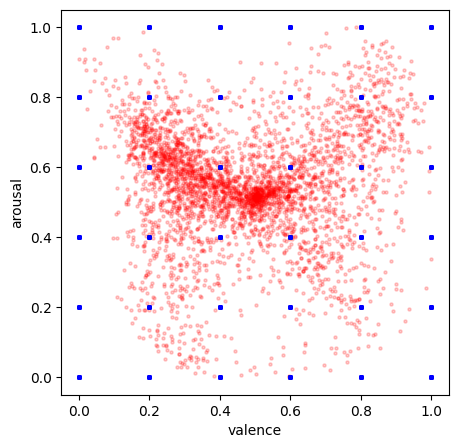

In [51]:
# plot the phrase VA ratings and anchor points
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
df.plot.scatter('rvaln','rarn', alpha=0.2, ax=axes, marker='.', color='red')
df.plot.scatter('valence', 'arousal', alpha=0.4, ax=axes, marker='.', color='blue')
plt.show()

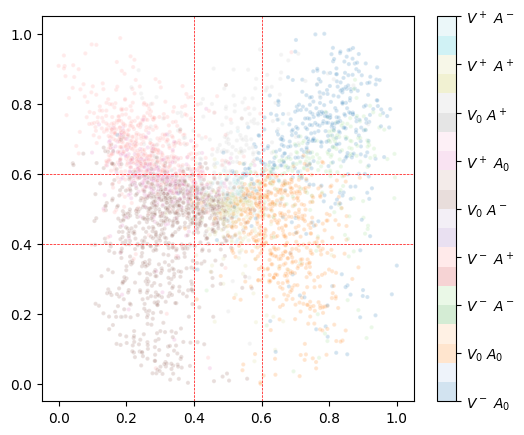

In [57]:
# colourise plot by anchor point category to show generated phrase matching

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
scatter = axes.scatter(df['rvaln'],df['rarn'], alpha=0.2, marker='.', c=df['catn'], cmap='tab20', edgecolor='white')
#legend1 = axes.legend(*scatter.legend_elements(num=9),
#                    loc="upper left", title="Categories")
#axes.add_artist(legend1)
cbar = fig.colorbar(scatter, ax=axes, cmap='tab20')
cbar.set_ticks(cbar.get_ticks(), labels=df['category'].unique())
#df.plot.scatter('valence', 'arousal', alpha=1, ax=axes, marker='D', c='catn', colormap='tab10', edgecolors='grey')
plt.axhline(y = 0.4, color = 'r', linestyle = '--', lw=0.5)
plt.axhline(y = 0.6, color = 'r', linestyle = '--', lw=0.5) 
plt.axvline(x = 0.6, color = 'r', linestyle = '--', lw=0.5) 
plt.axvline(x = 0.4, color = 'r', linestyle = '--', lw=0.5) 
plt.show()

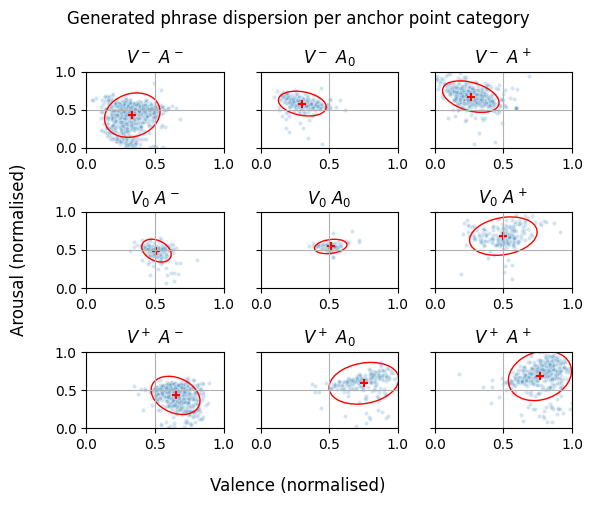

In [64]:
# probably clearer if visualised separately per anchor point category

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6, 5), sharey=True)

for i in range(0,3):
    for j in range (0,3):
        targetdf = df[df['category']==df['category'].unique()[i*3+j]]
        axes[i][j].scatter(targetdf['rvaln'],targetdf['rarn'], alpha=0.2, marker='.', edgecolor='white')
        axes[i][j].set_title(df['category'].unique()[i*3+j])
        axes[i][j].set_ylim(0,1)
        axes[i][j].set_xlim(0,1)
        #axes[i][j].set_xlabel('valence')
        #axes[i][j].set_ylabel('arousal')
        e, meanx, meany = confidence_ellipse(targetdf['rvaln'],targetdf['rarn'], ax=axes[i][j], n_std=1.96, edgecolor='red')
        axes[i][j].add_patch(e)
        axes[i][j].scatter(meanx, meany, color='red', marker='+')
        axes[i][j].grid()
fig.supxlabel('Valence (normalised)')
fig.supylabel('Arousal (normalised)')
fig.suptitle("Generated phrase dispersion per anchor point category")
plt.tight_layout()   
plt.show()


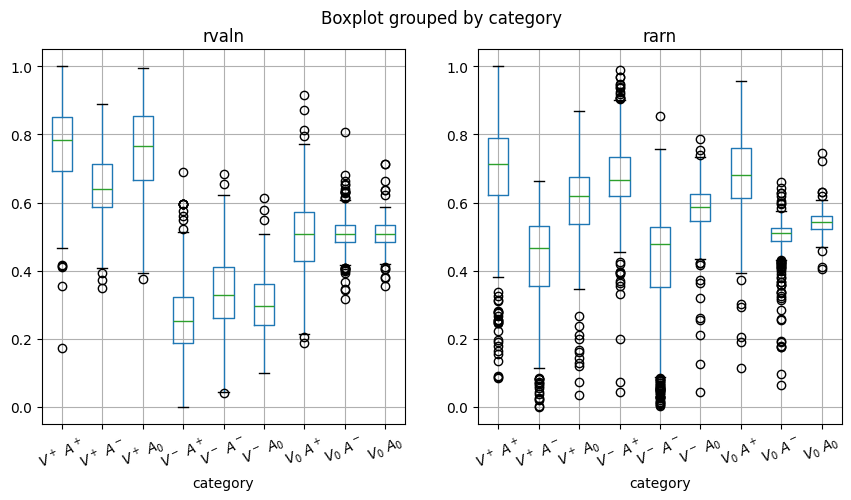

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
df.boxplot('rvaln', ax=axes[0], by='category')
df.boxplot('rarn', ax=axes[1], by='category')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation = 25)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation = 25)

plt.show()

In [65]:
df.groupby('calccategory').count()

,response,valence,arousal,rval,rar,rvaln,rarn,valbins,arbins,category,calcvalbins,calcarbins,catn,calccatn
calccategory,,,,,,,,,,,,,,
$V^+$ $A^+$,461,461,461,461,461,461,461,461,461,461,461,461,461,461
$V^+$ $A^-$,224,224,224,224,224,224,224,224,224,224,224,224,224,224
$V^+$ $A_0$,319,319,319,319,319,319,319,319,319,319,319,319,319,319
$V^-$ $A^+$,636,636,636,636,636,636,636,636,636,636,636,636,636,636
$V^-$ $A^-$,269,269,269,269,269,269,269,269,269,269,269,269,269,269
$V^-$ $A_0$,600,600,600,600,600,600,600,600,600,600,600,600,600,600
$V_0$ $A^+$,169,169,169,169,169,169,169,169,169,169,169,169,169,169
$V_0$ $A^-$,84,84,84,84,84,84,84,84,84,84,84,84,84,84
$V_0$ $A_0$,838,838,838,838,838,838,838,838,838,838,838,838,838,838


In [66]:
#get records where anchor point category matches generated phrase category
matcheddf = df[df['category']==df['calccategory']]
matcheddf.groupby('category').count()

,response,valence,arousal,rval,rar,rvaln,rarn,valbins,arbins,calcvalbins,calcarbins,calccategory,catn,calccatn
category,,,,,,,,,,,,,,
$V^+$ $A^+$,298,298,298,298,298,298,298,298,298,298,298,298,298,298
$V^+$ $A^-$,176,176,176,176,176,176,176,176,176,176,176,176,176,176
$V^+$ $A_0$,44,44,44,44,44,44,44,44,44,44,44,44,44,44
$V^-$ $A^+$,461,461,461,461,461,461,461,461,461,461,461,461,461,461
$V^-$ $A^-$,251,251,251,251,251,251,251,251,251,251,251,251,251,251
$V^-$ $A_0$,143,143,143,143,143,143,143,143,143,143,143,143,143,143
$V_0$ $A^+$,95,95,95,95,95,95,95,95,95,95,95,95,95,95
$V_0$ $A^-$,17,17,17,17,17,17,17,17,17,17,17,17,17,17
$V_0$ $A_0$,88,88,88,88,88,88,88,88,88,88,88,88,88,88


In [70]:
matcheddf.head(5)

,response,valence,arousal,rval,rar,rvaln,rarn,valbins,arbins,category,calcvalbins,calcarbins,calccategory,catn,calccatn
3,Idleness can lead to a sense of boredom.,0.0,0.0,-0.753666,-1.347325,0.360081,0.305959,$V^-$,$A^-$,$V^-$ $A^-$,$V^-$,$A^-$,$V^-$ $A^-$,4,4
4,We are sadly becoming increasingly bored with ...,0.0,0.0,-1.161615,-1.247252,0.286063,0.324769,$V^-$,$A^-$,$V^-$ $A^-$,$V^-$,$A^-$,$V^-$ $A^-$,4,4
5,A rainy day can be quite disheartening and lif...,0.0,0.2,-2.007665,-1.903682,0.132555,0.201381,$V^-$,$A^-$,$V^-$ $A^-$,$V^-$,$A^-$,$V^-$ $A^-$,4,4
17,It's often difficult to distinguish between a ...,0.0,0.6,-0.614250,-0.212766,0.385377,0.519219,$V^-$,$A_0$,$V^-$ $A_0$,$V^-$,$A_0$,$V^-$ $A_0$,5,5
19,Malnutrition can result from consuming a shitl...,0.0,0.6,-1.532772,0.057324,0.218720,0.569988,$V^-$,$A_0$,$V^-$ $A_0$,$V^-$,$A_0$,$V^-$ $A_0$,5,5


In [30]:
# export outermost corners and neutral areas as JSON files
sets = ['$V^+$ $A^+$','$V_0$ $A_0$','$V^-$ $A^-$','$V^+$ $A^-$','$V^-$ $A^+$']
fnames  = ['vp_ap', 'v0_a0', 'vn_an','vp_an','vn_ap']
for i in range(len(sets)):
    exportdf = matcheddf[matcheddf['category']==sets[i]].sample(n=75)
    exportdf[['response','valence','arousal','rval','rar']].to_json(fnames[i]+'.json', orient='records')

In [49]:
##### Compare with ENRON mobile email phrase set

In [67]:
path = "enron/mem"
result_files = glob.glob(path + "**")
print (result_files)

enrondf = pd.DataFrame(columns=['response', 'valence', 'arousal'])

for filepath in result_files:
    with open(filepath) as file:
        print('----')
        print(filepath)
        print('----')
        convos = file.readlines()
    #print(convos)
    responses = []
    valences = []
    arousals = []
    
    for convo in convos:
        try:
            v = -100
            a = -100
            r = convo.split('\t')[1].strip()
            responses.append(r)
            valences.append(v)
            arousals.append(a)
        except Exception as e:
            print (e)
            continue
    
    newdf = pd.DataFrame()
    newdf['response'] = responses
    newdf['valence'] = valences
    newdf['arousal'] = arousals
    enrondf = pd.concat([enrondf, newdf], axis=0)

print(len(enrondf))

scores = classifier(list(enrondf['response']),function_to_apply="none", top_k=None)
enrondf['rval'] = get_score_lists(scores)[0]
enrondf['rar'] = get_score_lists(scores)[1]

enrondf.head(5)

['enron/mem1.txt', 'enron/mem3.txt', 'enron/mem4.txt', 'enron/mem5.txt', 'enron/mem2.txt']
----
enron/mem1.txt
----
----
enron/mem3.txt
----
----
enron/mem4.txt
----
----
enron/mem5.txt
----
----
enron/mem2.txt
----
200


,response,valence,arousal,rval,rar
0,Are you going to join us for lunch?,-100,-100,0.305662,-0.671323
1,Is she done yet?,-100,-100,-0.020652,-0.947234
2,Thanks for the quick turnaround.,-100,-100,1.381569,0.472387
3,How are you?,-100,-100,0.577605,-0.577902
4,"Yes, I am playing.",-100,-100,-0.614452,0.562969


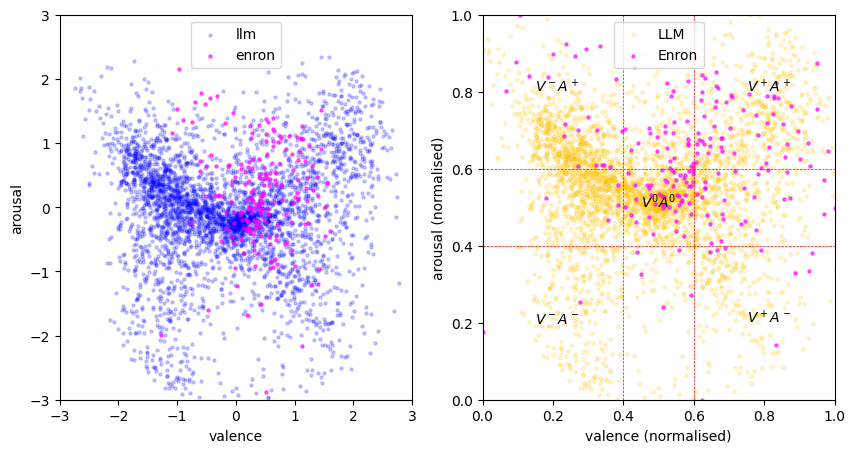

In [68]:
#min-max normalization - subtract min
#mean norm`- subtract mean
enrondf['rvaln'] = (enrondf['rval'] - enrondf['rval'].min()) / (enrondf['rval'].max() - enrondf['rval'].min())
enrondf['rarn'] = (enrondf['rar'] - enrondf['rar'].min()) / (enrondf['rar'].max() - enrondf['rar'].min())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
df.plot.scatter('rval','rar', alpha=0.2, ax=axes[0], marker='.', color='blue', label='llm')
enrondf.plot.scatter('rval','rar', alpha=0.6, ax=axes[0], marker='.', color='magenta', label='enron')
df.plot.scatter('rvaln','rarn', alpha=0.2, ax=axes[1], marker='.', color='yellow', edgecolor='orange', label='LLM')
enrondf.plot.scatter('rvaln','rarn', alpha=0.6, ax=axes[1], marker='.', color='magenta', label='Enron')
for i in range(len(axes)):
    if i%2==0:
        axes[i].set_xlim(-3,3)
        axes[i].set_ylim(-3,3)
        axes[i].set_xlabel('valence')
        axes[i].set_ylabel('arousal')
        axes[i].legend()
    else:
        axes[i].set_xlim(0,1)
        axes[i].set_ylim(0,1)
        axes[i].set_xlabel('valence (normalised)')
        axes[i].set_ylabel('arousal (normalised)')
        #axes[i].legend()
    
axes[1].axhline(y = 0.4, color = 'r', linestyle = '--', lw=0.5)
axes[1].axhline(y = 0.6, color = 'r', linestyle = '--', lw=0.5) 
axes[1].axvline(x = 0.6, color = 'r', linestyle = '--', lw=0.5) 
axes[1].axvline(x = 0.4, color = 'r', linestyle = '--', lw=0.5) 
axes[1].text(0.15,0.8,'$V^-A^+$')
axes[1].text(0.75,0.8,'$V^+A^+$')
axes[1].text(0.15,0.2,'$V^-A^-$')
axes[1].text(0.75,0.2,'$V^+A^-$')
axes[1].text(0.45,0.5,'$V^0A^0$')

plt.show()